In [1]:
import sys
import os

# add to path the additional modules implemented for PAVNET data analysis
sys.path.append("/home/aldo//notebooks/code/")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import firwin, filtfilt
import time
import gc
import fft_pavnet
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [3]:
data_path = "/data/savnet//"
!ls $data_path/raw_20min


data_raw_20min.csv  data_raw_26m.npy  structinfo.txt  wave_plo_pps.adicht


In [4]:
fnames = ["data_raw_26m.npy"] #["savnet_24h_p1.npy"]#, "savnet_24h_p2.npy", "savnet_24h_p3.npy", "savnet_24h_p4.npy", "savnet_24h_p5.npy"]

In [5]:
!cat $data_path/structinfo.txt

cat: /data/savnet///structinfo.txt: No such file or directory


In [6]:
n_samples= [2000001600, 2000001600, 2000001600, 2000001600, 303772800]
n_test = [1000*96000]
print("signal length=", sum(n_samples), "points")
print("test length=", n_test)

signal length= 8303779200 points
test length= [96000000]


In [7]:
fs = 96e3
samples_per_second = int(fs)
dt = 1/fs

fft_npts = 2**12

In [8]:
method = "overlap"

In [9]:
data = np.load(data_path+"/raw_20min/"+fnames[0], mmap_mode="r")

In [10]:
pps = data[:, 0]
xt  = data[:, 1] 


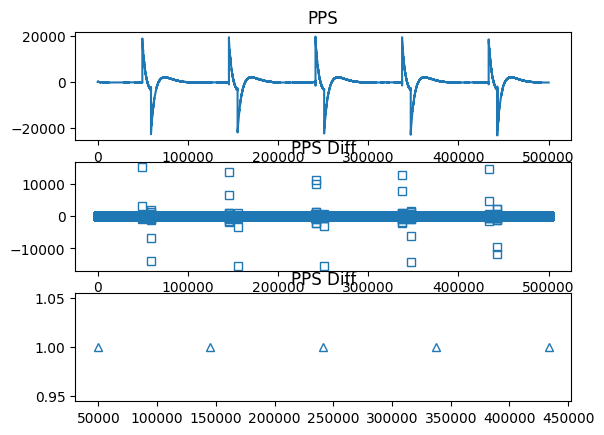

In [11]:
plt.subplot(311)
plt.title("PPS")
plt.plot(pps[0:500000])
plt.subplot(312)
plt.title("PPS Diff")
plt.plot(np.diff(pps[0:500000]), "s", markerfacecolor="none")
plt.subplot(313)
plt.title("PPS Diff")
plt.plot(np.where(np.diff(pps[0:500000])>10e3)[0], np.ones_like(np.where(np.diff(pps[0:500000])>10e3)[0]), 
         "^", markerfacecolor="none")


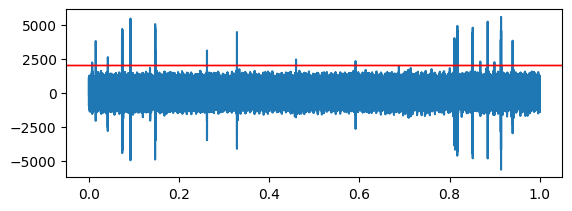

In [12]:
nn = 96000*1#4096
nn2 = 2**15
plt.subplot(211)
plt.plot(np.arange(nn)/96e3, xt[3*nn:4*nn])
plt.axhline(2e3, color="red", linewidth=1)
plt.axhline(2e3, color="red", linewidth=1)
Xw = fftshift(fft(xt[:nn]*np.hanning(nn)))
fw = fftshift(fftfreq(nn, 1/fs))
Xw_ = fftshift(fft(xt[:nn2]*np.hanning(nn2)))
fw_ = fftshift(fftfreq(nn2, 1/fs))


In [13]:
def get_ppstriggers(pps_signal, dref=96e3-10):
    pps_peaks, _ = signal.find_peaks(pps_signal,distance=dref)
    return pps_peaks

def butter_filt(s,cutoff, fs, ftype="lp", order=5):
    #return sp.signal.butter(order, cutoff, fs=fs, btype="low", analog=False)
    sos = signal.butter(order, cutoff, btype=ftype, fs=fs, output='sos')
    filtered = signal.sosfilt(sos, s)
    return filtered

In [14]:
triggers = get_ppstriggers(pps)

(0.0, 1000000.0)

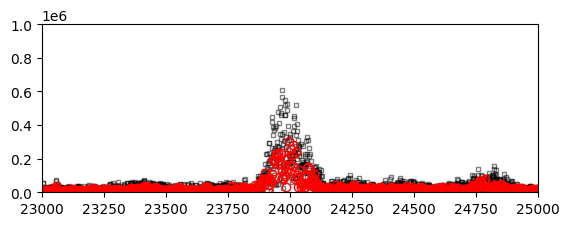

In [15]:
plt.subplot(212)
plt.plot(fw, abs(Xw), "sk",markersize=3, markerfacecolor="none", alpha=0.5)
plt.plot(fw_, abs(Xw_), "or", markerfacecolor="none")
plt.xlim(23e3, 25e3)
plt.ylim(0,top=10e5)

In [137]:
def moving_mean(x, w):
    return np.convolve(x, np.ones(w)/w, mode='same')

Text(0.5, 1.0, 'w hanning')

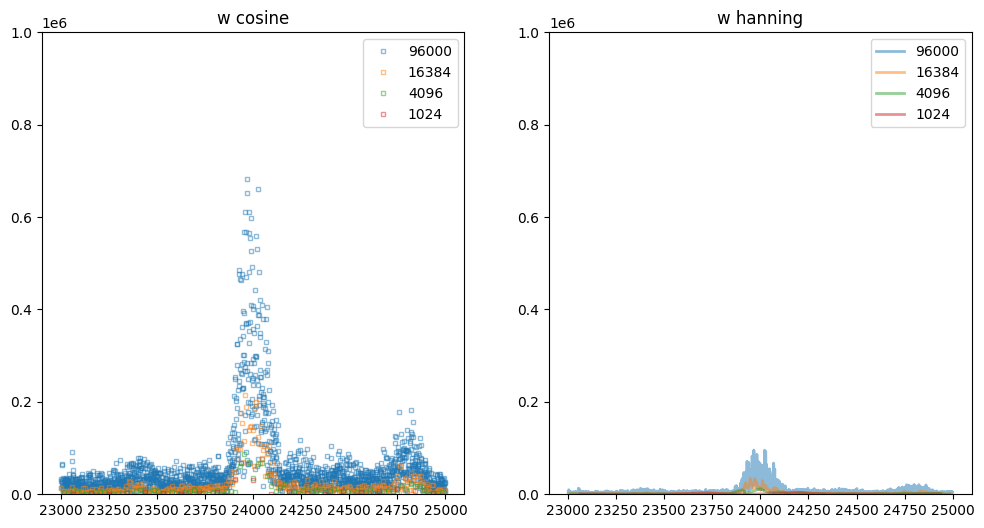

In [148]:
Nvalues = [1024,4096,int(2**14),int(96e3)]
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(121)



for nn in Nvalues[::-1]:
    f = fftshift(fftfreq(nn, 1/fs))
    mask = (f>23e3) & (f<25e3)
    fw = f[mask]
    Xw = fftshift(fft(xt[:nn]*signal.windows.cosine(nn)))[mask]
    
    plt.plot(fw, abs(Xw), "s",markersize=3, markerfacecolor="none", alpha=0.5, label=f"{nn}")

plt.legend()

#plt.xlim(23e3, 25e3)
plt.ylim(0,top=10e5)
plt.title("w cosine")

ax = plt.subplot(122)

for nn in Nvalues[::-1]:
    f = fftshift(fftfreq(nn, 1/fs))
    mask = (f>23e3) & (f<25e3)
    fw = f[mask]
    Xw = fftshift(fft(xt[:nn]*signal.windows.hann(nn)))[mask]
    Xw_smooth = Xw.copy()
    Xw_smooth.imag = moving_mean(Xw.imag, 5)
    Xw_smooth.real = moving_mean(Xw.real, 5)
    #plt.subplot(211)
    #plt.plot(fw, abs(Xw), "s",markersize=3, markerfacecolor="none", alpha=0.5, label=f"{nn}")
    plt.plot(fw, abs(Xw_smooth), "-",linewidth=2, alpha=0.5, label=f"{nn}")
plt.legend()
#plt.xlim(23e3, 25e3)
plt.ylim(0,top=10e5)
plt.title("w hanning")

In [24]:
ftx = 24e3
lp_filter = firwin(21, 100, fs=fs)
t_ = np.arange(samples_per_second)*dt
sig_dc = []
sig_dc_filt = []
t_arr = []
for k, i0 in enumerate(triggers[:-1]): 
    st = xt[i0:i0+samples_per_second]
    st = butter_filt(st, 12e3, ftype="hp", fs=fs)
    It = st * np.cos(2*np.pi*ftx*t_) 
    Qt = st * np.sin(2*np.pi*ftx*t_)
    It_filt = filtfilt(lp_filter, 1, It)
    Qt_filt = filtfilt(lp_filter, 1, Qt)
    sig_dc.append(It+1j*Qt)
    sig_dc_filt.append(It_filt+1j*Qt_filt)
    t_arr.append(i0)


In [21]:
del sig_dc 
del sig_dc_filt
gc.collect()    

972

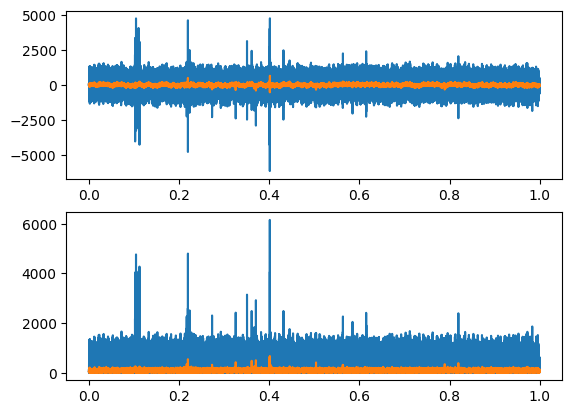

In [25]:
#gc.collect()
fig = plt.figure()
ax=plt.subplot(211)
plt.plot(t_, sig_dc[0].real)
plt.plot(t_, sig_dc_filt[0].real)
ax=plt.subplot(212, sharex=ax)
plt.plot(t_, np.sqrt(sig_dc[0].real**2 + sig_dc_filt[0].imag**2))
plt.plot(t_, np.sqrt(sig_dc_filt[0].real**2 + sig_dc_filt[0].imag**2))

#ax.set_xlim(0,5000)

In [ ]:
plt.plot(sig_dc_filt[0].real)

In [68]:
del fig 
del ax

In [83]:
npts_fft = samples_per_second#2**12
X0 = fftshift(fft(st, npts_fft)) 
X = fftshift(fft(sig_dc[-1], npts_fft))
Xf = fftshift(fft(sig_dc_filt[-1], npts_fft))
freq = fftshift(fftfreq(npts_fft, 1/fs))

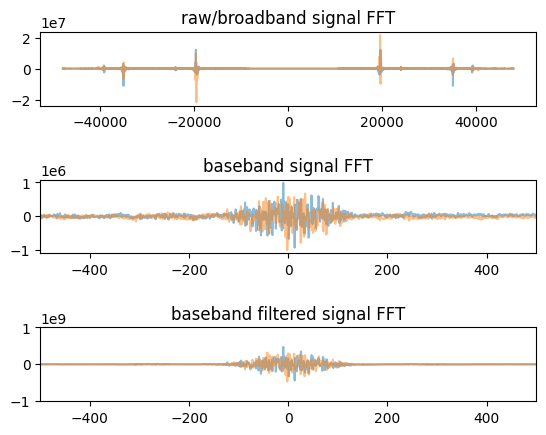

In [93]:
fig = plt.figure()
ax = plt.subplot(311)
ax.plot(freq, X0.real, alpha=0.5)
ax.plot(freq, X0.imag, alpha=0.5)
ax.set_title("raw/broadband signal FFT")

ax = plt.subplot(312, )#sharex=ax, sharey=ax)
ax.plot(freq, X.real, alpha=0.5)
ax.plot(freq, X.imag, alpha=0.5)
ax.set_title("baseband signal FFT")

ax = plt.subplot(313, sharex=ax, )
ax.plot(freq, Xf.real, alpha=0.5)
ax.plot(freq, Xf.imag, alpha=0.5)
ax.set_title("baseband filtered signal FFT")
ax.set_xlim(-500,500)
ax.set_ylim(-1000e6, 1000e6)

plt.subplots_adjust(hspace=1)

In [103]:
x_anglet = np.arctan2(It,Qt)
XX_fft = fftshift(fft((It+1j*Qt)*signal.windows.hann(len(It)), 
                      norm="forward"))
XXang_fft = fftshift(fft(x_anglet*signal.windows.hann(len(It)), norm="forward"))
ffreq = fftshift(fftfreq(len(XXang_fft), 1/fs))

<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_282802/856811891.py:6: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel("$\phi$=arg(I+jQ)")
/tmp/ipykernel_282802/856811891.py:14: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel("$\phi$=arg(I+jQ)")


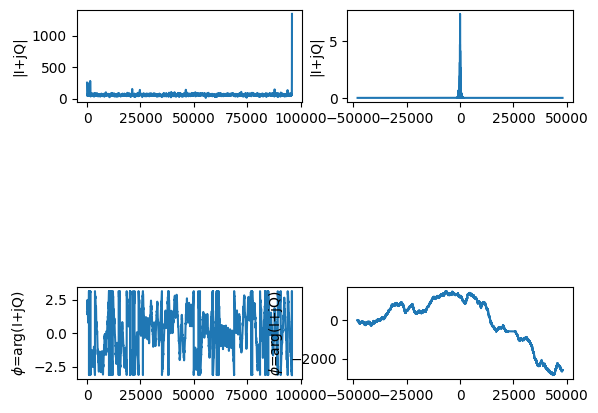

In [108]:
plt.subplot(221)
plt.ylabel("|I+jQ|")
plt.plot(abs(It+1j*Qt))

plt.subplot(223)
plt.ylabel("$\phi$=arg(I+jQ)")
plt.plot(x_anglet)

ax_fft = plt.subplot(222)
plt.ylabel("|I+jQ|")
plt.plot(ffreq, abs(XX_fft))

plt.subplot(224, sharex=ax_fft)
plt.ylabel("$\phi$=arg(I+jQ)")
plt.plot(ffreq, np.unwrap(np.angle(XX_fft)))
#ax_fft.set_xlim(-200,200)
plt.subplots_adjust(hspace=2)

In [28]:
X_win = X[(-100<freq) & (freq<100)]
Xf_win = Xf[(-100<freq) & (freq<100)]
f_win = freq[(-100<freq) & (freq<100)]

In [ ]:
ax = plt.subplot(312, )#sharex=ax, sharey=ax)




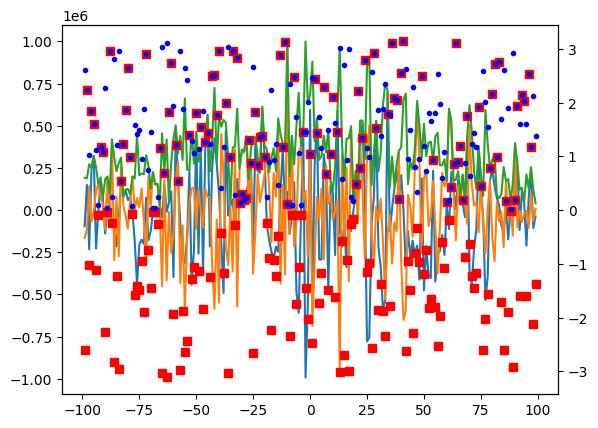

In [29]:
ax = plt.subplot()
#plt.plot(f_win, X_win.imag)
plt.plot(f_win, Xf_win.imag)
#plt.plot(f_win, X_win.i)
plt.plot(f_win, Xf_win.real)
plt.plot(f_win, abs(Xf_win))
ax2 = ax.twinx()
ax2.plot(f_win, np.arctan2(Xf_win.imag, Xf_win.real),"sr")
ax2.plot(f_win, abs(np.arctan2(Xf_win.imag, Xf_win.real)),".b")
#ax2.plot(f_win, np.arctan(Xf_win),"sr")
X_win_ = X_win.copy(); Xf_win_ = Xf_win.copy()
X_win_[::2] *= -1
Xf_win_[::2] *= -1


## for a reduced windows of fft_nmpts

In [30]:
ftx = 24e3
lp_filter = firwin(21, 100, fs=fs)
t_ = np.arange(samples_per_second)*dt
sig_dc = []
sig_dc_filt = []
t_arr = []
for k, i0 in enumerate(triggers[:-1]): 
    st = xt[i0:i0+samples_per_second]
    st = butter_filt(st, 12e3, ftype="hp", fs=fs)
    It = st * np.cos(2*np.pi*ftx*t_) 
    Qt = st * np.sin(2*np.pi*ftx*t_)
    It_filt = filtfilt(lp_filter, 1, It)
    Qt_filt = filtfilt(lp_filter, 1, Qt)
    sig_dc.append(It+1j*Qt)
    sig_dc_filt.append(It_filt+1j*Qt_filt)
    t_arr.append(i0)

In [31]:
npts_fft = 2**11
X0 = fftshift(fft(st, npts_fft)) 
X = fftshift(fft(sig_dc[1], npts_fft))
Xf = fftshift(fft(sig_dc_filt[1], npts_fft))
freq = fftshift(fftfreq(npts_fft, 1/fs))

(-100000.0, 100000.0)

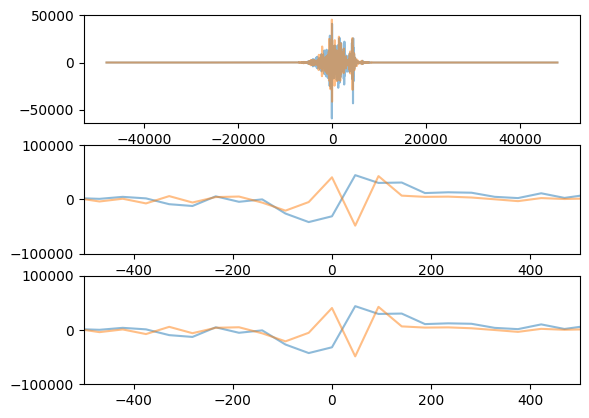

In [85]:
fig = plt.figure()
ax = plt.subplot(311)
ax.plot(freq, X0.real, alpha=0.5)
ax.plot(freq, X0.imag, alpha=0.5)

ax = plt.subplot(312, )#sharex=ax, sharey=ax)
ax.plot(freq, X.real, alpha=0.5)
ax.plot(freq, X.imag, alpha=0.5)

ax = plt.subplot(313, sharex=ax, sharey=ax)
ax.plot(freq, Xf.real, alpha=0.5)
ax.plot(freq, Xf.imag, alpha=0.5)
ax.set_xlim(-500,500)
ax.set_ylim(-100000, 100000)

In [33]:
X_win = X[(-100<freq) & (freq<100)]
Xf_win = Xf[(-100<freq) & (freq<100)]
f_win = freq[(-100<freq) & (freq<100)]

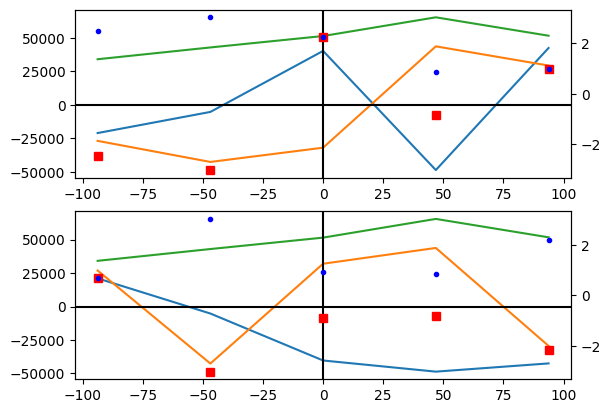

In [34]:
ax = plt.subplot(211)
#plt.plot(f_win, X_win.imag)
plt.plot(f_win, Xf_win.imag)
#plt.plot(f_win, X_win.i)
plt.plot(f_win, Xf_win.real)
plt.plot(f_win, abs(Xf_win))
ax2 = ax.twinx()
ax2.plot(f_win, np.arctan2(Xf_win.imag, Xf_win.real),"sr")
ax2.plot(f_win, abs(np.arctan2(Xf_win.imag, Xf_win.real)),".b")
#ax2.plot(f_win, np.arctan(Xf_win),"sr")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')

X_win_ = X_win.copy(); Xf_win_ = Xf_win.copy()
X_win_[::2] *= -1
Xf_win_[::2] *= -1
ax = plt.subplot(212)
plt.plot(f_win, Xf_win_.imag)
#plt.plot(f_win, X_win.i)
plt.plot(f_win, Xf_win_.real)
plt.plot(f_win, abs(Xf_win_))
ax2 = ax.twinx()
ax2.plot(f_win, np.arctan2(Xf_win_.imag, Xf_win_.real),"sr")
ax2.plot(f_win, abs(np.arctan2(Xf_win_.imag, Xf_win_.real)),".b")
ax2.set_title("")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')


In [84]:
f_win

array([-93.75 , -46.875,   0.   ,  46.875,  93.75 ])

### tracking

In [78]:
npts_fft = 2*1024#4096
signals_ts = np.asarray(sig_dc_filt)
print(signals_ts.shape)
freq = fftshift(fftfreq(npts_fft, 1/fs))
f_win = freq[(-100<freq) & (freq<100)]
ftx_arr = []
comp_arr = []
for k, s_ in enumerate(signals_ts):
    #s_ = signals_ts
    X0 = fftshift(fft(s_[:npts_fft]*np.hanning(npts_fft) )) 
    #X = fftshift(fft(sig_dc[1], npts_fft))
    #Xf = fftshift(fft(sig_dc_filt[1], npts_fft))
    #X_win_ = X_win.copy(); Xf_win_ = Xf_win.copy()
    X0_ = X0.copy()
    X_win = X0_[(-100<freq) & (freq<100)]
    
    X_win[::2] *= -1
    #Xf_win_[::2] *= -1
    
    #Xf_win = Xf[(-100<freq) & (freq<100)]
    ii = np.argmax(abs(X_win))
    ftx = f_win[ii]
    Xi_tx = X_win[ii]
    comp_arr.append(Xi_tx)
    ftx_arr.append(ftx)
comp_arr = np.asarray(comp_arr)
ftx_arr = np.asarray(ftx_arr)

(1573, 96000)


In [79]:
phi = np.arctan2(comp_arr.imag, comp_arr.real)

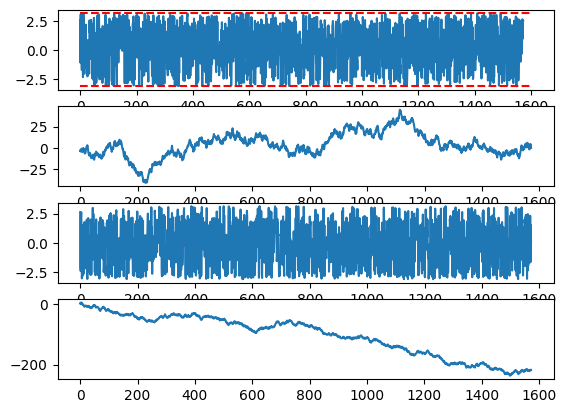

In [142]:
plt.subplot(411)
plt.plot(phi)
plt.hlines([-np.pi, np.pi], 0,1600, ls="--", color="r")
plt.subplot(412)
plt.plot(np.unwrap(np.diff(phi)))

plt.subplot(413)
plt.plot(np.diff(np.unwrap(phi)))

plt.subplot(414)
plt.plot(np.unwrap(phi))

In [ ]:
def burst_filt(s, nsigma):
    sigma_ = np.std(s)
    
def butter_filt(s,cutoff, fs, order=5, fc=12e3):
    #return sp.signal.butter(order, cutoff, fs=fs, btype="low", analog=False)
    sos = sp.signal.butter(order, fc, btype='hp', fs=fs, output='sos')
    filtered = sp.signal.sosfilt(sos, s)
    return filtered

def butter_lpf(st, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = sp.signal.lfilter(b, a, st)
    return y

def IQ_quadrature(st, fs, fc, integrate=False, of=4):
    t = np.arange(len(st))/fs; L=2*of
    xi = np.cos(2*np.pi*fc*t)*st  
    xq = -np.sin(2*np.pi*fc*t)*st
    Tb = of/fs
    x = 1#abs(np.cos(np.pi*t/(2*Tb)))
    y = 1#abs(np.sin(np.pi*t/(2*Tb)))

    xi = xi*x
    xq = xq*y
    cutoff_f = 100
    xi = butter_lpf(xi, cutoff_f, fs)
    xq = butter_lpf(xq, cutoff_f, fs)
    if integrate:
        int_xi = integrator(xi, L)
        int_xq = integrator(xq, L)
        return int_xi, int_xq
    return xi, xq

def integrator(st, n=None):
    # st 1d, not complex
    # concvulution
    if not n:
        n=len(st)
    return np.convolve(st, np.ones(n))
    
    

In [11]:
f0 = 30e3
bw = 30e3
sampling_freq = fs
fft_npts_ovlp = fft_npts #2**12
povlp = 50
tio = time.time()
#fnames1 = fnames[1035:2070] # por partes
if method == "single":
    freq_w = np.arange(fft_npts)*sampling_freq/fft_npts
    id_0 = np.argmin(abs(freq_w-(f0-bw/2)))
    id_f = np.argmin(abs(freq_w-(f0+bw/2)))    
    freq_wtrim = freq_w[id_0:id_f]
    freq_wtrim = freq_w[id_0:id_f]
elif method == "overlap":
    freq_w_ovlp = np.arange(fft_npts_ovlp)*sampling_freq/fft_npts_ovlp
    id_0 = np.argmin(abs(freq_w_ovlp-(f0-bw/2)))
    id_f = np.argmin(abs(freq_w_ovlp-(f0+bw/2)))
    freq_wtrim = freq_w_ovlp[id_0:id_f]
nfiles = len(fnames)
time_arr = []
fftv =[]

samples_per_signal = int(2**14)
delta_samples = int(10*fs)
s = []
for k, f in enumerate(fnames):
    n = n_samples[k]
    #print("File {:60s}\t {:7d} of {:7d} processed \t -> {:3.2f} %".format(f,k+1, nfiles, round((k+1)*100/nfiles, 2) ),end="\r")
    print(f"File {f} :: processing {n}... ", end="\n")
    filesignal = np.load(data+f)
    start, end = 0, delta_samples-len(s)
    count = 1
    
        
    while end <=n:
        wend = start + samples_per_signal # windows end
        st = filesignal[start: wend] if not len(s) else np.concatenate((s, filesignal[start: end]))[0:wend]
        #st = st[:,0]+1j*st[:,1]  # signal IQ fmt
        #time_arr.append(tools.get_date_from_fname(f))
        #print("\napplying FFT {}".format(method))
        if method == "single":
            fftv.append(fft_pavnet.fft_window(st, wlen=fft_npts,fw=signal.windows.flattop)[id_0:id_f,:])
        elif method == "overlap":
            S = fft_pavnet.fft_overlap(st, wlen=fft_npts_ovlp,
                                       wfun=signal.windows.flattop, 
                                       povlp=povlp, ret_freq=False, shift=False)[id_0:id_f]
            fftv.append(S)
        else:
            
            break
        count += 1
        start += delta_samples
        end = start + delta_samples
        print(" ∟--> {:3.2f}%".format(100*start/n_samples[k]), end="\r")
    s = filesignal[start:]    
    print(f" ∟--> 100 % completed. N {count} its.")    
        #del data_signal1
    
print("\n>>>> Completed <<<<\nin {} s".format(time.time()-tio))
#fftv = np.asarray(fftv)

NameError: name 'fnames' is not defined

In [31]:
xx = fft_pavnet.fft_window(st, wlen=fft_npts,fw=signal.windows.flattop)

In [43]:
fft_pavnet.fft_overlap(st, wlen=fft_npts_ovlp,
                                       wfun=signal.windows.flattop, 
                                       povlp=50, ret_freq=False)[id_0:id_f]

array([1193.21464565])

In [11]:
fftv.shape

AttributeError: 'list' object has no attribute 'shape'

In [11]:
del filesignal, S
gc.collect()

850

In [12]:
fftv = np.asarray(fftv).T

In [13]:
data = pd.DataFrame(fftv, index=freq_wtrim)

In [14]:
data.shape

(1280, 8648)

In [15]:
cutfreq =[16,26]
#data.columns = data.columns + datetime.timedelta(hours=5)
COMP_FACT = 1 # compesacion dado que ese l nuevo bit

plt.rcParams["fon.size"]=14

KeyError: 'fon.size is not a valid rc parameter (see rcParams.keys() for a list of valid parameters)'

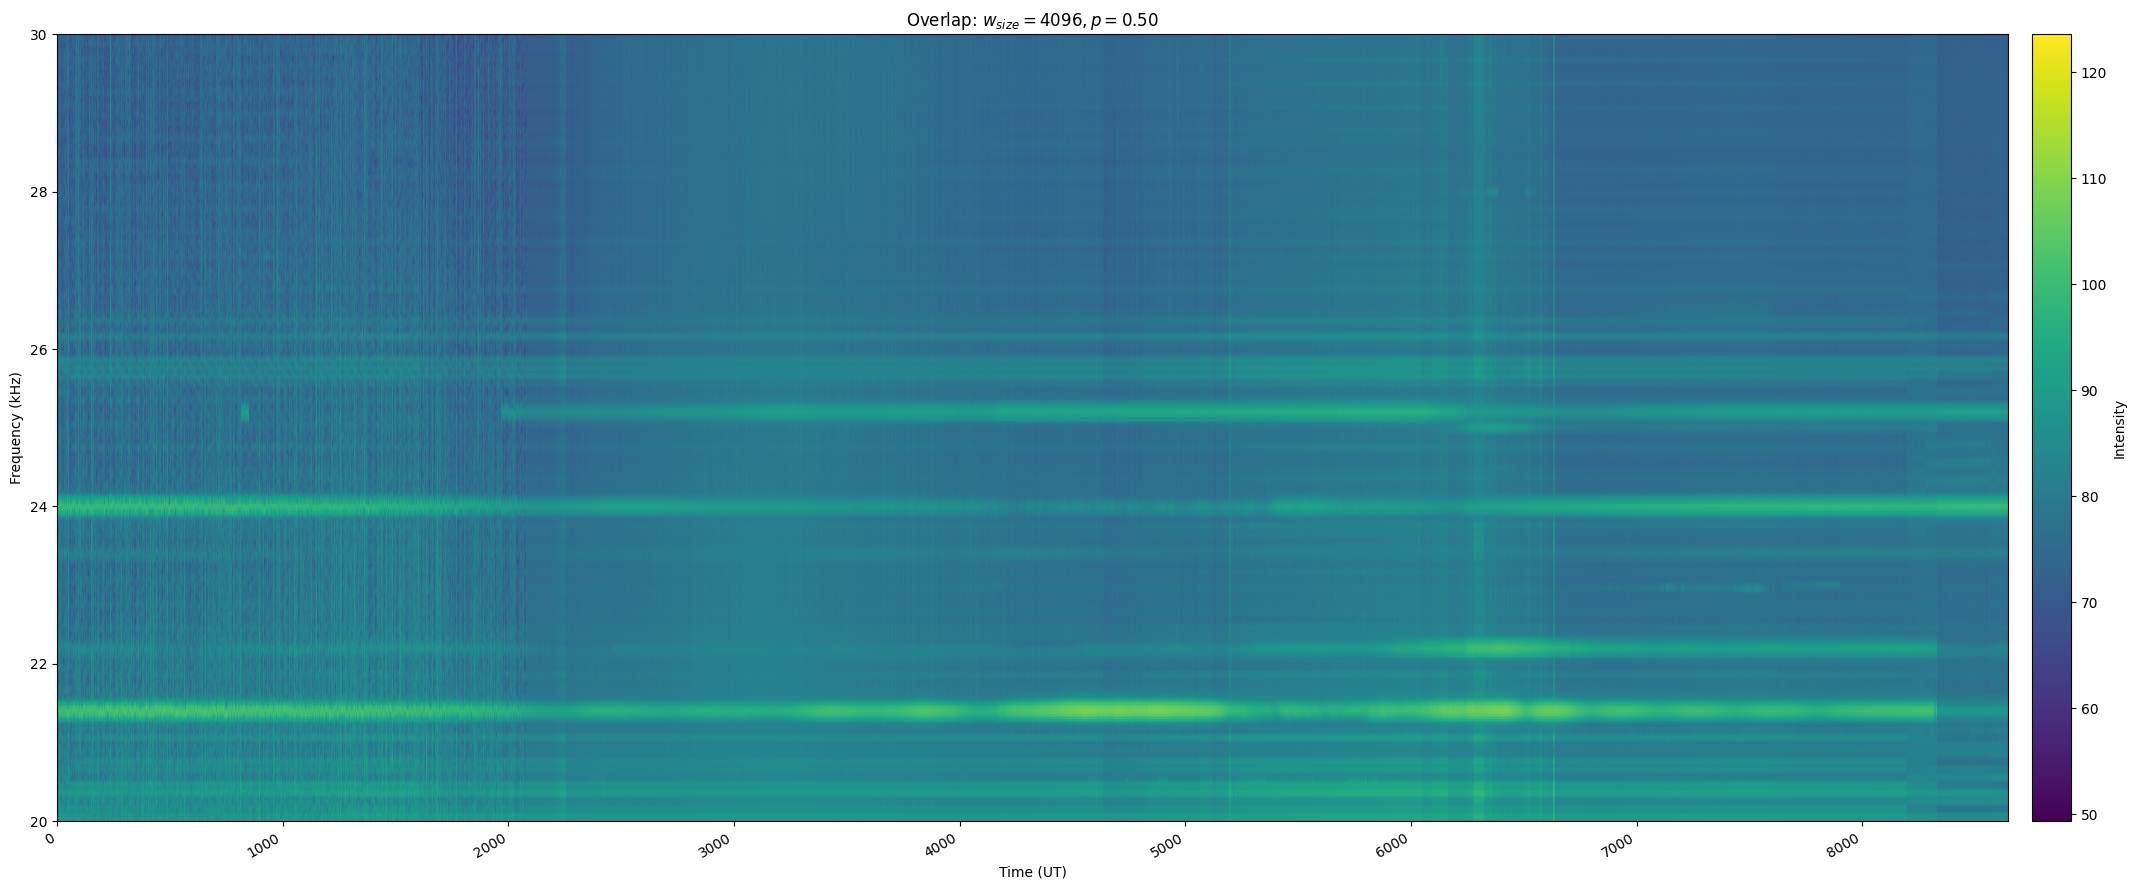

In [16]:
#spectrogram
ut = True

fig, ax = plt.subplots(figsize=(24,9))

props = dict(boxstyle='round', facecolor='wheat', alpha=1)

vmax=10
vmin=-20


#cm = ax.pcolormesh(np.asanyarray(timev), freq_wtrim/1000, np.abs(fftv),shading="auto", vmin=0, vmax=vmax )
if ut:
    
    cm = ax.pcolormesh(data.columns, freq_wtrim/1000, 20*np.log10(np.abs(data.values*COMP_FACT)),shading='nearest',)# vmax=vmax, vmin=vmin)#,norm=norm_, )
else:
    cm = ax.pcolormesh(timev, freq_wtrim/1000, np.abs(fftv),shading='nearest',norm=norm_, vmin=0, vmax=0.5)
#cm = ax.pcolormesh(timev1, freq_w, fftv1,vmin=0,vmax=1 )
ax.set_ylim((20, 30))
if ut:
    ax.set_xlabel("Time (UT)")
else:
    ax.set_xlabel("Local Time")
ax.set_ylabel("Frequency (kHz)")
ax.set_title("Overlap: $w_{size}=%d, p=%.2f $"%(fft_npts_ovlp, povlp/100))

fig.autofmt_xdate()
plt.colorbar(cm, ax=ax, pad=0.01, label="Intensity")
#ax.vlines(185,f0-bw/2,f0+bw/2)
#ax.set_ylim(cutfreq)
#ax.set_xlim((1000,1050))
#ax.yaxis.set_minor_locator(AutoMinorLocator(5))
#ax.xaxis.set_minor_locator(AutoMinorLocator(5))
#ax.set_xlim(datetime.datetime(2023,8,12), datetime.datetime(2023,10,15))
#ax.set_xlim(right =  datetime.datetime(2022,7,2,12))
#ax.set_ylim(top=10)
plt.tight_layout()
#fig.savefig("spectogram_savnet24h_bymethodPavnet.png".format(data.columns[0], data.columns[-1], cutfreq[0], cutfreq[1]), dpi=300)

#plt.grid(which='both', axis='x', linestyle=':')

In [28]:
fftv.shape

(1, 8648)

file: 7500


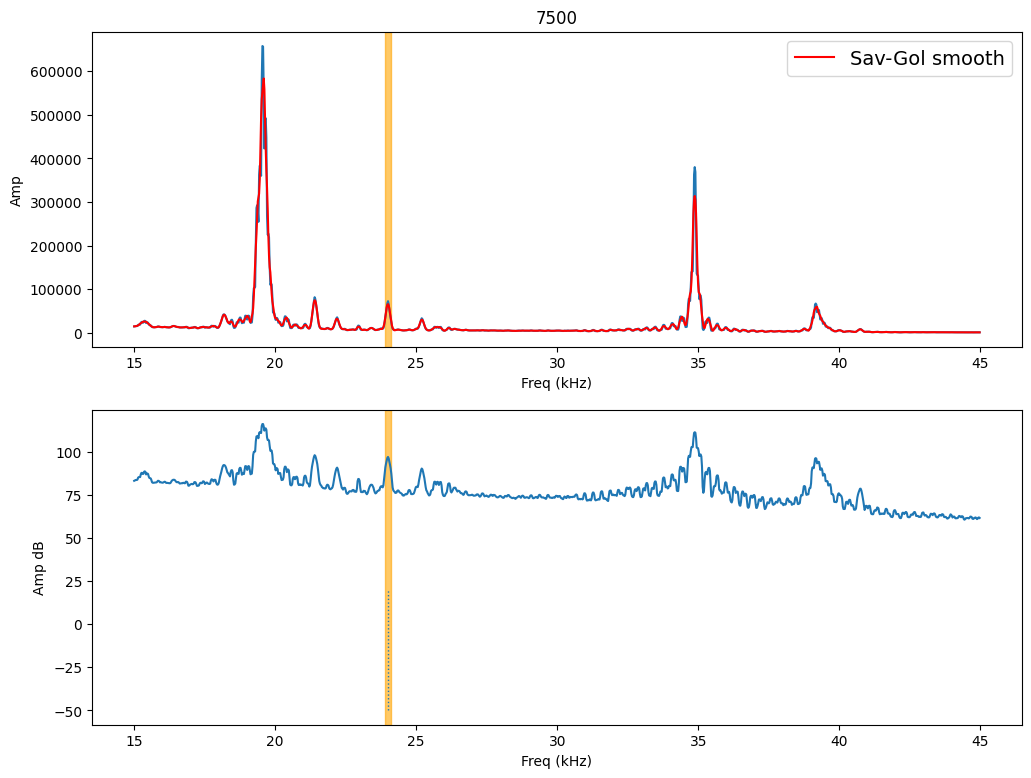

In [17]:
index = 7500

fig = plt.figure(figsize=(12,9))
ax = plt.subplot(211)
plt.plot(freq_wtrim/1e3,data.iloc[:,index])

plt.axvspan(23.9, 24.1, color='orange',alpha=0.6)
plt.xlabel('Freq (kHz)')
plt.ylabel('Amp')
plt.title(data.columns[index])
plt.plot(freq_wtrim/1e3, signal.savgol_filter(data.iloc[:,index],11,2,axis=0), color="r", label="Sav-Gol smooth")
plt.legend(fontsize=14)

plt.subplot(212, sharex=ax)
plt.plot(freq_wtrim/1e3,20*np.log10(data.iloc[:,index]))
plt.axvspan(23.9, 24.1, color='orange',alpha=0.6)
plt.xlabel('Freq (kHz)')
plt.ylabel('Amp dB')
#plt.ylim(-50,15)
plt.vlines(24,ymin=-50, ymax=20,linewidth=1, linestyle=":")


#plt.xlim(15,30)
print(f"file: {data.columns[index]}")

In [20]:
import numpy as np

In [19]:
sxx = np.fft.fft(st,2**12)
fxx = np.fft.fftfreq(len(sxx),1/fs)

(0.0, 200000.0)

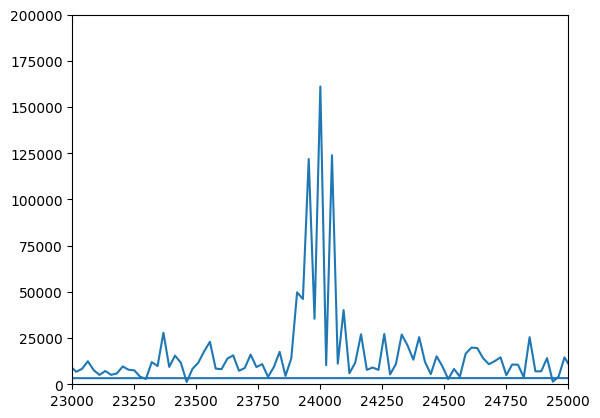

In [20]:
plt.plot(fxx,abs(sxx))
plt.xlim(23e3,25e3)
plt.ylim(0,2e5)

In [34]:
len(sxx)

1281600

19800.0
21400.0
22200.0
24000.0
24800.0
25200.0


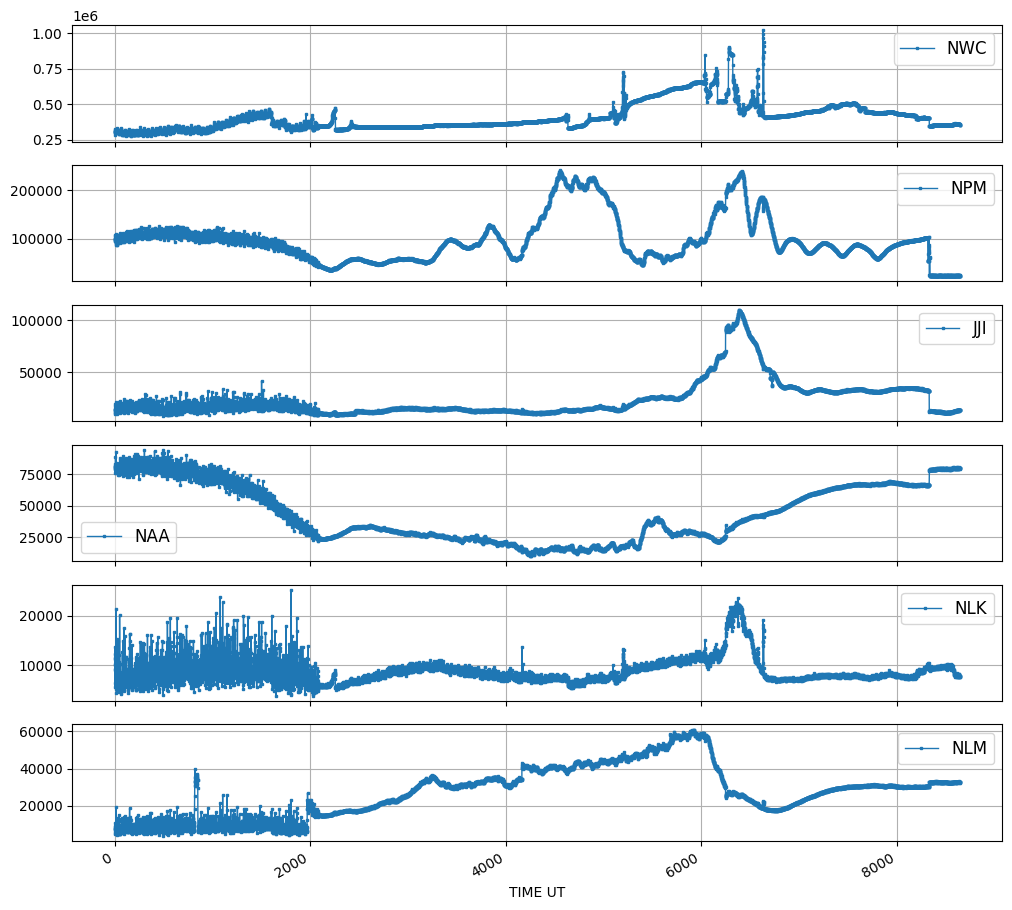

In [26]:
vlf_transmitters = {
                    "NWC":19.8e3, 
                    "NPM":21.4e3, 
                    "JJI":22.2e3,
                    "NAA":24.0e3, 
                    "NLK":24.8e3, 
                    "NLM":25.2e3
                    }
freq_wtrim = data.index
COMP_FACT=1
n = len(vlf_transmitters)
fig, axs = plt.subplots(n,1,figsize=(12,12),sharex=True)
#axs[0].set_title(str(fft_npts_ovlp) + " npts")

f0 = 24e3
bw=350

nbdata_sg = {}
nbdata = {}

for ii, vlfname in  enumerate(vlf_transmitters):
    f0 = vlf_transmitters[vlfname]
    print(f0)
    id_0 = np.argmin(abs(freq_wtrim-(f0-bw/2)))
    id_f = np.argmin(abs(freq_wtrim-(f0+bw/2)))

    #amp_curve = track(fftv,freq_wtrim, ftarget=vlf_transmitters[vlfname], bw=200)
    amp_curve = np.max(data.values[id_0:id_f,:],axis=0)
    amp_curve_sg = np.max(signal.savgol_filter(data.values[id_0:id_f,:]*COMP_FACT, 11,2,axis=0),axis=0)
    axs[ii].plot(data.columns, amp_curve_sg,label=vlfname, linewidth=1, marker="s", markersize=2)
    axs[ii].legend(fontsize=12)
    axs[ii].grid()
    nbdata_sg[vlfname] = amp_curve_sg
    nbdata[vlfname] = amp_curve
    
#axs[-1].set_xlim(left= datetime.datetime(2023,10,13,0,0), right= datetime.datetime(2023,10,13,1,))
axs[-1].set_xlabel("TIME UT")
fig.autofmt_xdate()

In [46]:
np.mean(np.diff(fxx[0:10]))

23.4375

In [22]:
id_0, id_f

(908, 918)

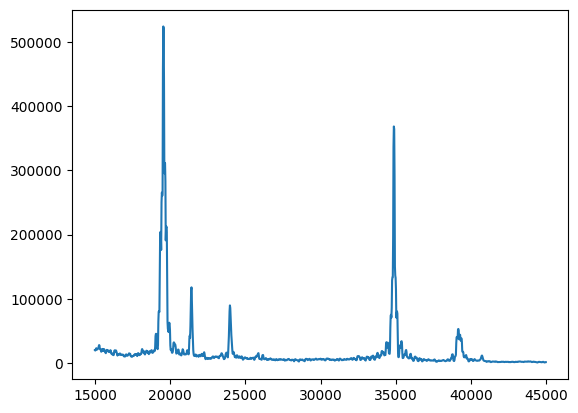

In [24]:
plt.plot(data[1])

In [25]:
data.index

Index([   15000.0, 15023.4375,  15046.875, 15070.3125,   15093.75, 15117.1875,
        15140.625, 15164.0625,    15187.5, 15210.9375,
       ...
        44765.625, 44789.0625,    44812.5, 44835.9375,  44859.375, 44882.8125,
         44906.25, 44929.6875,  44953.125, 44976.5625],
      dtype='float64', length=1280)

In [28]:
refmin=np.mean(pd.DataFrame(nbdata).mean(numeric_only=True))

In [30]:
nbdata_db = pd.DataFrame()
for tx in vlf_transmitters:

    nbdata_db[tx]= 20*np.log10(nbdata[tx]/refmin)

In [31]:
%store -r refdata_naa

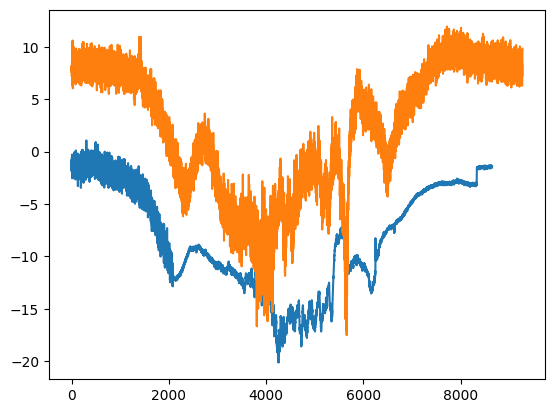

In [32]:
plt.plot(nbdata_db["NAA"])
plt.plot(refdata_naa)

In [64]:
def snr_along_signal(s, w):
    '''
    Calculates the snr along a discrete signal s by a moving window of size w
    s: array-like signal 
    w: int, window size, must be smaller to s

    Returns an array of snr and the index related to position in signal
     [t,snr]
    '''
    if w>len(s):
        raise("Error: window size cannot be greater than signal.")
    if type(s) != np.ndarray:
        s = np.asarray(s)
    midp = w//2
    n = len(s)
    p = 0
    ti = []
    snr = []
    while p < n-midp:
        i = p+midp
        x = s[p:i]
        m = np.mean(x)
        err_mse = sum((x-m)**2)/n
        ti.append(i)
        snr.append(abs(m)/err_mse)
        p += midp
    return np.asarray(ti), np.asarray(snr)

def minmax_scale(s):
    vmin = min(s)
    vmax = max(s)

    return (np.asarray(s) - vmin)/(vmax-vmin)
    

## Somewhere


In [16]:

ftx = 24e3
hp_filter = firwin(211, 12e3, fs=fs, pass_zero="highpass")
lp_filter = firwin(211, 100, fs=fs, pass_zero="lowpass")
t_ = np.arange(samples_per_second)*dt
sig_dc = []
sig_dc_filt = []
t_arr = []
fb = 200
Tb = 1/fb
L = int(2*fs / fb) # samples in 2Tb (baud period)  
ut = np.ones(L)
for k, i0 in enumerate(triggers[:2]): 
    st = xt[i0:i0+samples_per_second]
    #st = butter_filt(st, 12e3, ftype="hp", fs=fs)
    st = filtfilt(hp_filter, 1, st)
    It = st * np.cos(2*np.pi*ftx*t_) 
    Qt = st * np.sin(2*np.pi*ftx*t_)
    It = filtfilt(lp_filter, 1, It)
    Qt = filtfilt(lp_filter, 1, Qt)
    It_filt = np.convolve(It, ut, mode="valid")
    Qt_filt = np.convolve(Qt, ut, mode="valid")
    sig_dc.append(It+1j*Qt)
    sig_dc_filt.append(It_filt+1j*Qt_filt)
    t_arr.append(i0)

In [17]:
It_filt_ = np.convolve(It, ut, mode="same")
Qt_filt_ = np.convolve(Qt, ut, mode="same")

(np.float64(-0.049999479166666666), np.float64(1.0499890625))

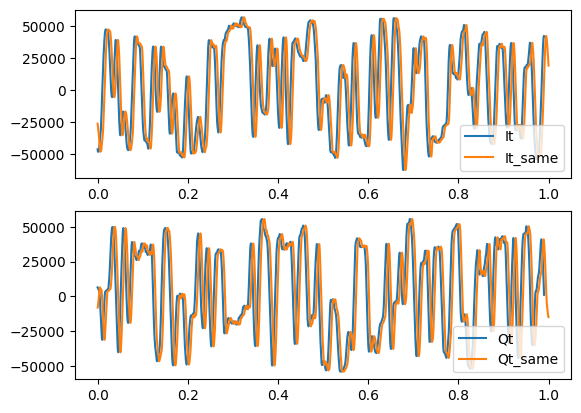

In [18]:
ax = plt.subplot(211)
plt.plot(t_[:len(It_filt)], It_filt, label="It")
plt.plot(t_, It_filt_, label="It_same")
plt.legend()
plt.subplot(212, sharex=ax)
plt.plot(t_[:len(It_filt)], Qt_filt, label="Qt")
plt.plot(t_, Qt_filt_, label="Qt_same")
plt.legend()
plt.xlim()

In [110]:
L*5e-3

2.4

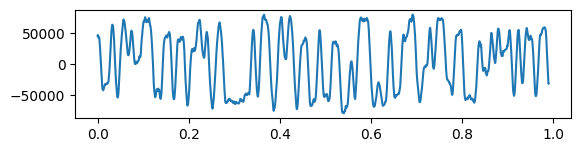

In [17]:
plt.subplot(312, sharex=ax)
plt.plot(t_[:len(It_filt)], It_filt+Qt_filt)

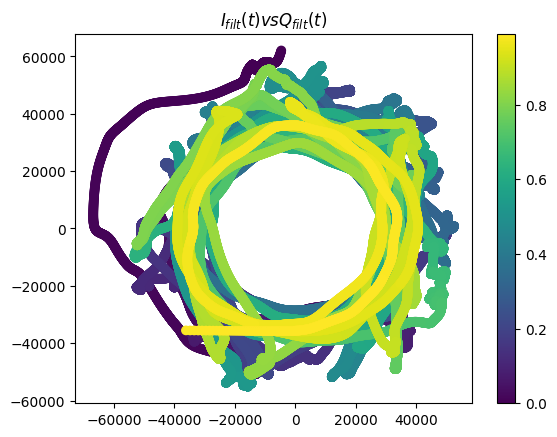

In [118]:
fig = plt.figure()
plt.scatter(Qt_filt, It_filt, c=t_[:len(It_filt)])
plt.title("$I_{filt}(t) vs Q_{filt}(t)$")
plt.colorbar()

### Following what is decribed in 
Lower ionosphere effects on narrowband VLF transmission propagation: fast variabilities and frequency dependence
Kuang Liang Koh , Zhongjian Liu , Martin Füllekrug

In [18]:
phi_r = np.arctan2(It_filt, Qt_filt)
#phi_r = np.arctan2(It, Qt)

<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_321446/764349416.py:3: SyntaxWarning: invalid escape sequence '\p'
  plt.title("unwrapped $\phi_r$")
/tmp/ipykernel_321446/764349416.py:4: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel("$\phi_r$ (º)")


Text(0, 0.5, '$\\phi_r$ (º)')

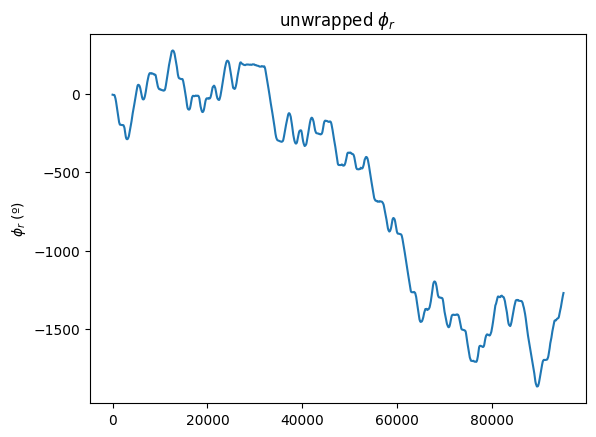

In [20]:
#plt.plot((phi_r)*180/np.pi)
plt.plot(np.unwrap(phi_r)*180/np.pi)
plt.title("unwrapped $\phi_r$")
plt.ylabel("$\phi_r$ (º)")

In [21]:
omega_i1 = np.diff(phi_r)/np.diff(t_[:len(It_filt)])
omega_i2 = np.diff(np.unwrap(phi_r))/np.diff(t_[:len(It_filt)])
#omega_i1 = np.diff(phi_r)/np.diff(t_[:len(It)])
#omega_i2 = np.diff(np.unwrap(phi_r))/np.diff(t_[:len(It)])


(0.0, 4800.0)

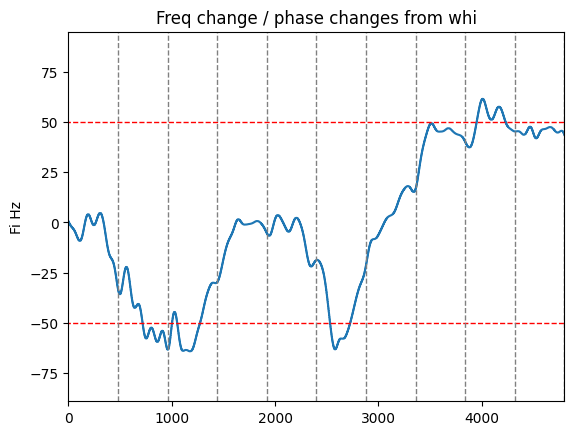

In [44]:
#plt.subplot(211)
#plt.plot(omega_i1/(2*np.pi))

#plt.subplot(212)
fig = plt.figure()
#plt.plot(omega_i2/(2*np.pi), )#marker=".", markerfacecolor="none", markeredgecolor="black")
plt.step(np.arange(len(omega_i2)), omega_i2/(2*np.pi), )
plt.ylabel("Fi Hz")
plt.title("Freq change / phase changes from whi")
plt.hlines([-50, 50], -1e3, 1e5, linestyle="--", color ="red", linewidth=1)
nb = 10
samples_per_bit = 480
for i in range(nb):
    plt.axvline((i+1)*samples_per_bit, ls="--", color="gray", lw=1)

plt.xlim(0, nb*samples_per_bit)



### hilbert transform

In [ ]:
npts = int(2**12) 
It_hat = signal.hilbert(It_filt, npts)
Qt_hat = signal.hilbert(Qt_filt, npts)

In [31]:
f, t , Sxx = signal.spectrogram(It_filt[:int(4800/2)], fs=96e3, nperseg=480, mode="magnitude", return_onesided=False)

IndexError: index 5 is out of bounds for axis 0 with size 5

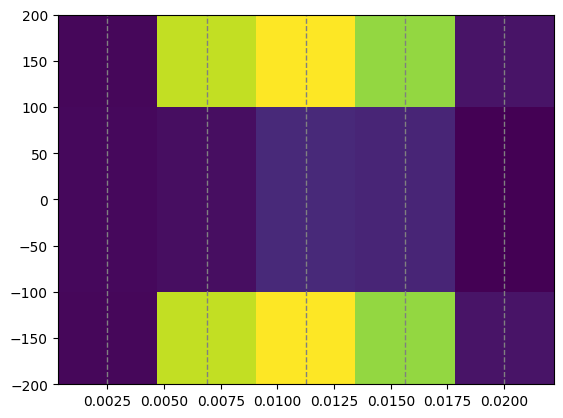

In [38]:
plt.pcolormesh(t,fftshift(f), fftshift(Sxx, axes=0))
plt.ylim(-200,200)
for i in range(int(fs/480)): plt.axvline(t[(i)], ls="--", color="gray", lw=1)


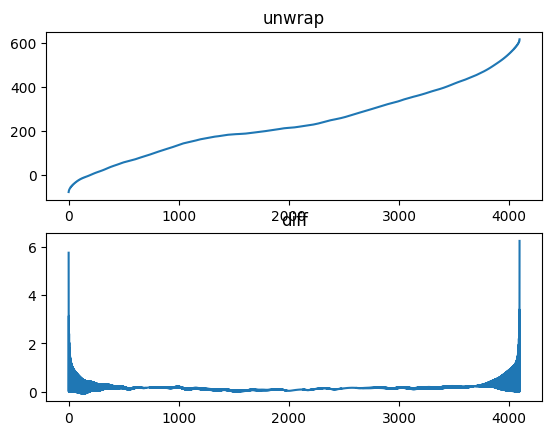

In [54]:

plt.subplot(211)
plt.title("unwrap")
plt.plot(180/3.14*np.unwrap(np.arctan2((It_hat.imag + Qt_hat.imag),(It_hat.real + Qt_hat.real))))

plt.subplot(212)
plt.title("diff")
plt.plot(180/3.14*np.diff(np.unwrap(np.arctan2((It_hat.imag + Qt_hat.imag),(It_hat.real + Qt_hat.real)))))
         

### I/Q x sin/cos ¡? 

In [19]:
fm = 50
t = t_[:len(It_filt)]
High_x = It_filt * np.cos(2 * np.pi * fm * t)
High_y = Qt_filt * np.sin(2 * np.pi * fm * t)
Low_x  = It_filt * np.sin(2 * np.pi * fm * t)
Low_y  = Qt_filt * np.cos(2 * np.pi * fm * t)

# Filtrado Paso Bajo
num_taps = 311  # Orden del filtro
lpf = signal.firwin(num_taps, cutoff=50, window="flattop", fs=fs)

In [20]:
sos = signal.butter(11, 50, btype='lp', fs=fs, output='sos')
#filtered = sp.signal.sosfilt(sos, s)
w, h = signal.freqz_sos(sos, worN=1500, fs=fs)
db = 20*np.log10(np.maximum(np.abs(h), 1e-5))

ntaps:111 , t = 0.017447471618652344
ntaps:211 , t = 0.0004112720489501953
ntaps:311 , t = 0.0002968311309814453
ntaps:411 , t = 0.00029540061950683594
ntaps:511 , t = 0.0003371238708496094


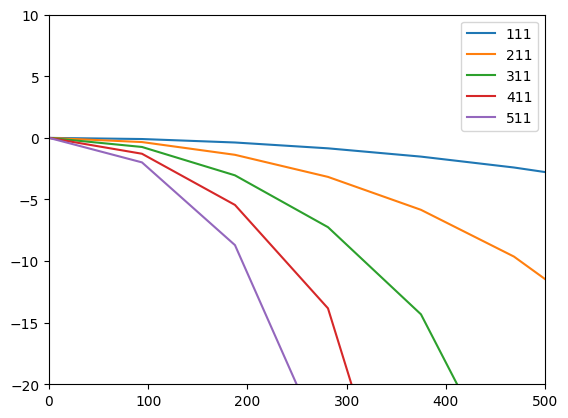

In [21]:
num_taps = 111

for i in range(5):
    numtaps = 111+100*i
    ti = time.time()
    lpf = signal.firwin(numtaps, cutoff=50, window=("kaiser",4), 
                        fs=fs, pass_zero="lowpass")
    w, h = signal.freqz(lpf, fs=fs)
    tf = time.time()
    print(f"ntaps:{numtaps} , t = {tf-ti}")
    db = 20*np.log10(np.maximum(np.abs(h), 1e-5))
    plt.plot(w, db, label=f"{numtaps}")
plt.xlim(0,500)
plt.ylim(-20,10)
plt.legend()

In [22]:
High_x_filt = signal.lfilter(lpf, 1.0, High_x)
High_y_filt = signal.lfilter(lpf, 1.0, High_y)
Low_x_filt  = signal.lfilter(lpf, 1.0, Low_x)
Low_y_filt  = signal.lfilter(lpf, 1.0, Low_y)

In [23]:
phi_c = np.arctan2(
                        High_y_filt+High_x_filt, Low_y_filt+Low_x_filt)


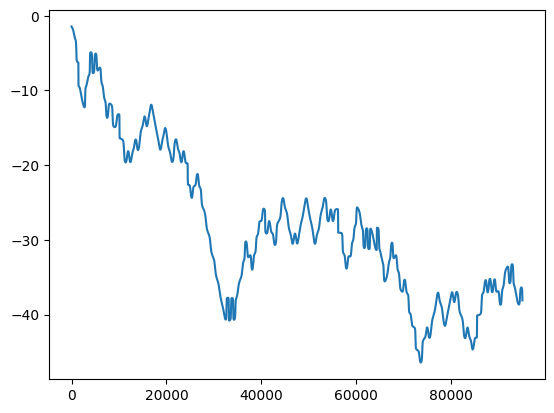

In [24]:
plt.plot(np.unwrap(phi_c))

(-200.0, 200.0)

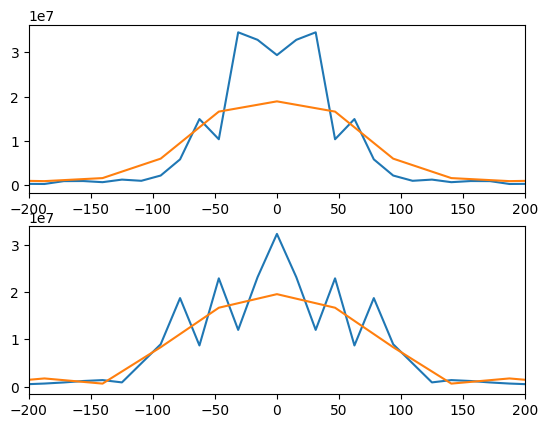

In [182]:
nn = 6*1024 #samples_per_second
plt.subplot(211)
ff_ = fftshift(fftfreq(nn,1/fs))
plt.plot(ff_ , abs(fftshift(fft(It_filt[:nn]*signal.windows.hann(nn)))))
nn2 = 2*1024 #samples_per_second
ff_ = fftshift(fftfreq(nn2,1/fs))
plt.plot(ff_ , abs(fftshift(fft(It_filt[:nn2]*signal.windows.hann(nn2)))))
plt.xlim(-200, 200)

plt.subplot(212)
ff_ = fftshift(fftfreq(nn,1/fs))
plt.plot(ff_ , abs(fftshift(fft(Qt_filt[:nn]*signal.windows.hann(nn)))))

ff_ = fftshift(fftfreq(nn2,1/fs))
plt.plot(ff_ , abs(fftshift(fft(Qt_filt[:nn2]*signal.windows.hann(nn2)))))
plt.xlim(-200, 200)

In [183]:
L

480

In [169]:

signal.windows.hann

<function scipy.signal.windows._windows.hann(M, sym=True)>